In [4]:
import torch
import xgboost as xgb
from model.LSTM_base_model import test_start_date, test_end_date,T_values
from model.my_xgboost import lstm_to_xgboost

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bst = xgb.Booster()
target_T = 7

bst.load_model(f'../model/xgb_models/xgb_model_{target_T}.json')

In [5]:
X_test, Y_test = lstm_to_xgboost(test_start_date, test_end_date, target_T)

In [6]:
# 将数据转换为DMatrix对象，XGBoost专用的数据结构
dtest = xgb.DMatrix(X_test)

# 预测，使用iteration_range指定使用的树的范围
# bst.best_iteration 是在训练时通过early stopping找到的最佳迭代次数
best_iteration = bst.best_iteration if hasattr(bst, 'best_iteration') else None
if best_iteration is not None:
    Y_pred = bst.predict(dtest, iteration_range=(0, best_iteration + 1))
else:
    # 如果没有使用早停或找不到最佳迭代次数，直接预测
    Y_pred = bst.predict(dtest)

In [7]:
X_test

,lstm_1_Y_pred,lstm_3_Y_pred,lstm_7_Y_pred,lstm_15_Y_pred,lstm_30_Y_pred
2022-11-02,0.00067990,0.00238452,0.00254680,0.00281102,0.00161066
2022-11-03,0.00025408,0.00514446,0.00213970,0.00246082,0.00089076
2022-11-04,0.00009576,0.00295672,0.00303733,0.00284931,0.00074393
2022-11-07,-0.00000947,-0.00436213,0.00176995,0.00203137,0.00062064
2022-11-08,-0.00028879,-0.00491330,0.00236697,0.00143314,0.00061638
...,...,...,...,...,...
2023-08-22,0.00160331,-0.00083833,-0.00465897,-0.00152581,-0.00188194
2023-08-23,0.00184983,0.00008971,-0.00135104,-0.00052155,-0.00208625
2023-08-24,0.00187033,-0.00190074,0.00042263,0.00022126,-0.00200827
2023-08-25,0.00194799,-0.00285270,-0.00067948,-0.00022978,-0.00184887


In [8]:
# 打印Y_pred和Y_test的形状
print(Y_pred.shape, Y_test.shape)

(214,) (214,)


In [9]:
# 将Y_pred和Y_test合并为一个DataFrame，方便查看
import pandas as pd
df = pd.DataFrame({'Y_pred': Y_pred, 'Y_test': Y_test})
df

,Y_pred,Y_test
2022-11-02,0.00192214,0.00424328
2022-11-03,0.00238493,0.00551081
2022-11-04,0.00318608,0.00339071
2022-11-07,0.00100830,0.00231016
2022-11-08,0.00123395,0.00254901
...,...,...
2023-08-22,-0.00589650,-0.00111899
2023-08-23,-0.00312890,-0.00052507
2023-08-24,-0.00030219,-0.00223389
2023-08-25,-0.00179950,-0.00335520


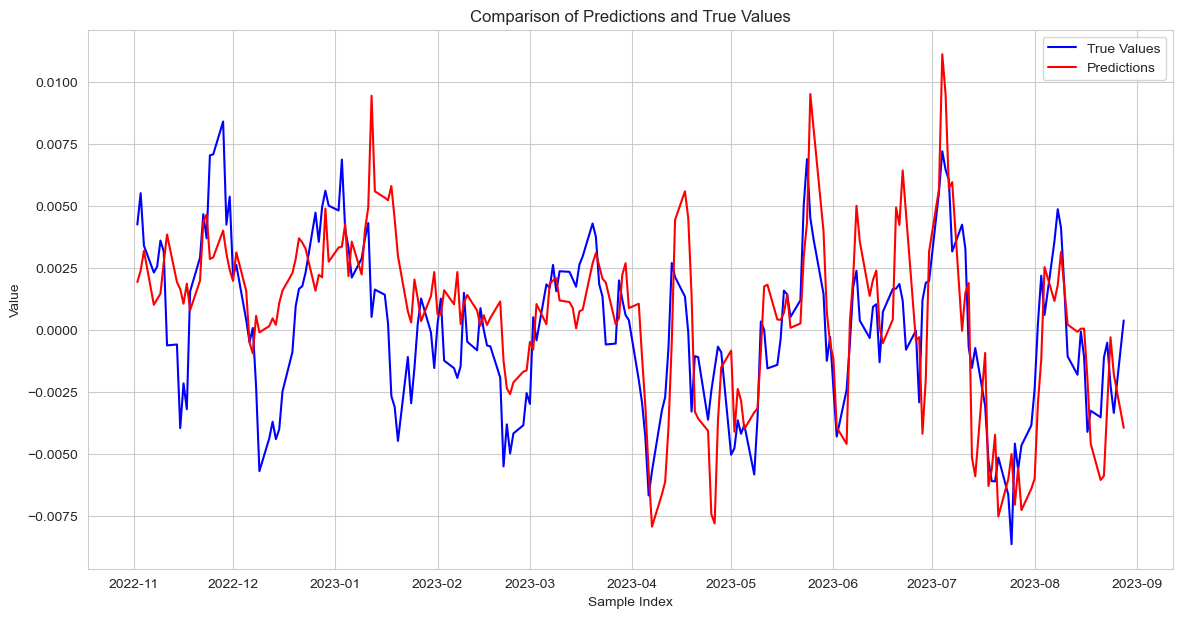

In [10]:
import matplotlib.pyplot as plt

# 设置绘图尺寸
plt.figure(figsize=(14, 7))

# 绘制真实值
plt.plot(df['Y_test'], label='True Values', color='blue')

# 绘制预测值
plt.plot(df['Y_pred'], label='Predictions', color='red')

# 添加标题和坐标轴标签
plt.title('Comparison of Predictions and True Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [11]:
# 将Y_test, Y_pred,X_test 合并

df_all = X_test
df_all['XGB/FLIXNet_pred'] = Y_pred
df_all['Y_true'] = Y_test
df_all

,lstm_1_Y_pred,lstm_3_Y_pred,lstm_7_Y_pred,lstm_15_Y_pred,lstm_30_Y_pred,XGB/FLIXNet_pred,Y_true
2022-11-02,0.00067990,0.00238452,0.00254680,0.00281102,0.00161066,0.00192214,0.00424328
2022-11-03,0.00025408,0.00514446,0.00213970,0.00246082,0.00089076,0.00238493,0.00551081
2022-11-04,0.00009576,0.00295672,0.00303733,0.00284931,0.00074393,0.00318608,0.00339071
2022-11-07,-0.00000947,-0.00436213,0.00176995,0.00203137,0.00062064,0.00100830,0.00231016
2022-11-08,-0.00028879,-0.00491330,0.00236697,0.00143314,0.00061638,0.00123395,0.00254901
...,...,...,...,...,...,...,...
2023-08-22,0.00160331,-0.00083833,-0.00465897,-0.00152581,-0.00188194,-0.00589650,-0.00111899
2023-08-23,0.00184983,0.00008971,-0.00135104,-0.00052155,-0.00208625,-0.00312890,-0.00052507
2023-08-24,0.00187033,-0.00190074,0.00042263,0.00022126,-0.00200827,-0.00030219,-0.00223389
2023-08-25,0.00194799,-0.00285270,-0.00067948,-0.00022978,-0.00184887,-0.00179950,-0.00335520


In [12]:
for T in T_values:
    # 对于每个 T，检查列名是否存在，然后进行替换
    old_column_name = f'model_{T}_Y_pred'
    new_column_name = f'lstm_T={T}_pred'  # 修正列名格式
    if old_column_name in df_all.columns:
        df_all.rename(columns={old_column_name: new_column_name}, inplace=True)

df_all


,lstm_1_Y_pred,lstm_3_Y_pred,lstm_7_Y_pred,lstm_15_Y_pred,lstm_30_Y_pred,XGB/FLIXNet_pred,Y_true
2022-11-02,0.00067990,0.00238452,0.00254680,0.00281102,0.00161066,0.00192214,0.00424328
2022-11-03,0.00025408,0.00514446,0.00213970,0.00246082,0.00089076,0.00238493,0.00551081
2022-11-04,0.00009576,0.00295672,0.00303733,0.00284931,0.00074393,0.00318608,0.00339071
2022-11-07,-0.00000947,-0.00436213,0.00176995,0.00203137,0.00062064,0.00100830,0.00231016
2022-11-08,-0.00028879,-0.00491330,0.00236697,0.00143314,0.00061638,0.00123395,0.00254901
...,...,...,...,...,...,...,...
2023-08-22,0.00160331,-0.00083833,-0.00465897,-0.00152581,-0.00188194,-0.00589650,-0.00111899
2023-08-23,0.00184983,0.00008971,-0.00135104,-0.00052155,-0.00208625,-0.00312890,-0.00052507
2023-08-24,0.00187033,-0.00190074,0.00042263,0.00022126,-0.00200827,-0.00030219,-0.00223389
2023-08-25,0.00194799,-0.00285270,-0.00067948,-0.00022978,-0.00184887,-0.00179950,-0.00335520


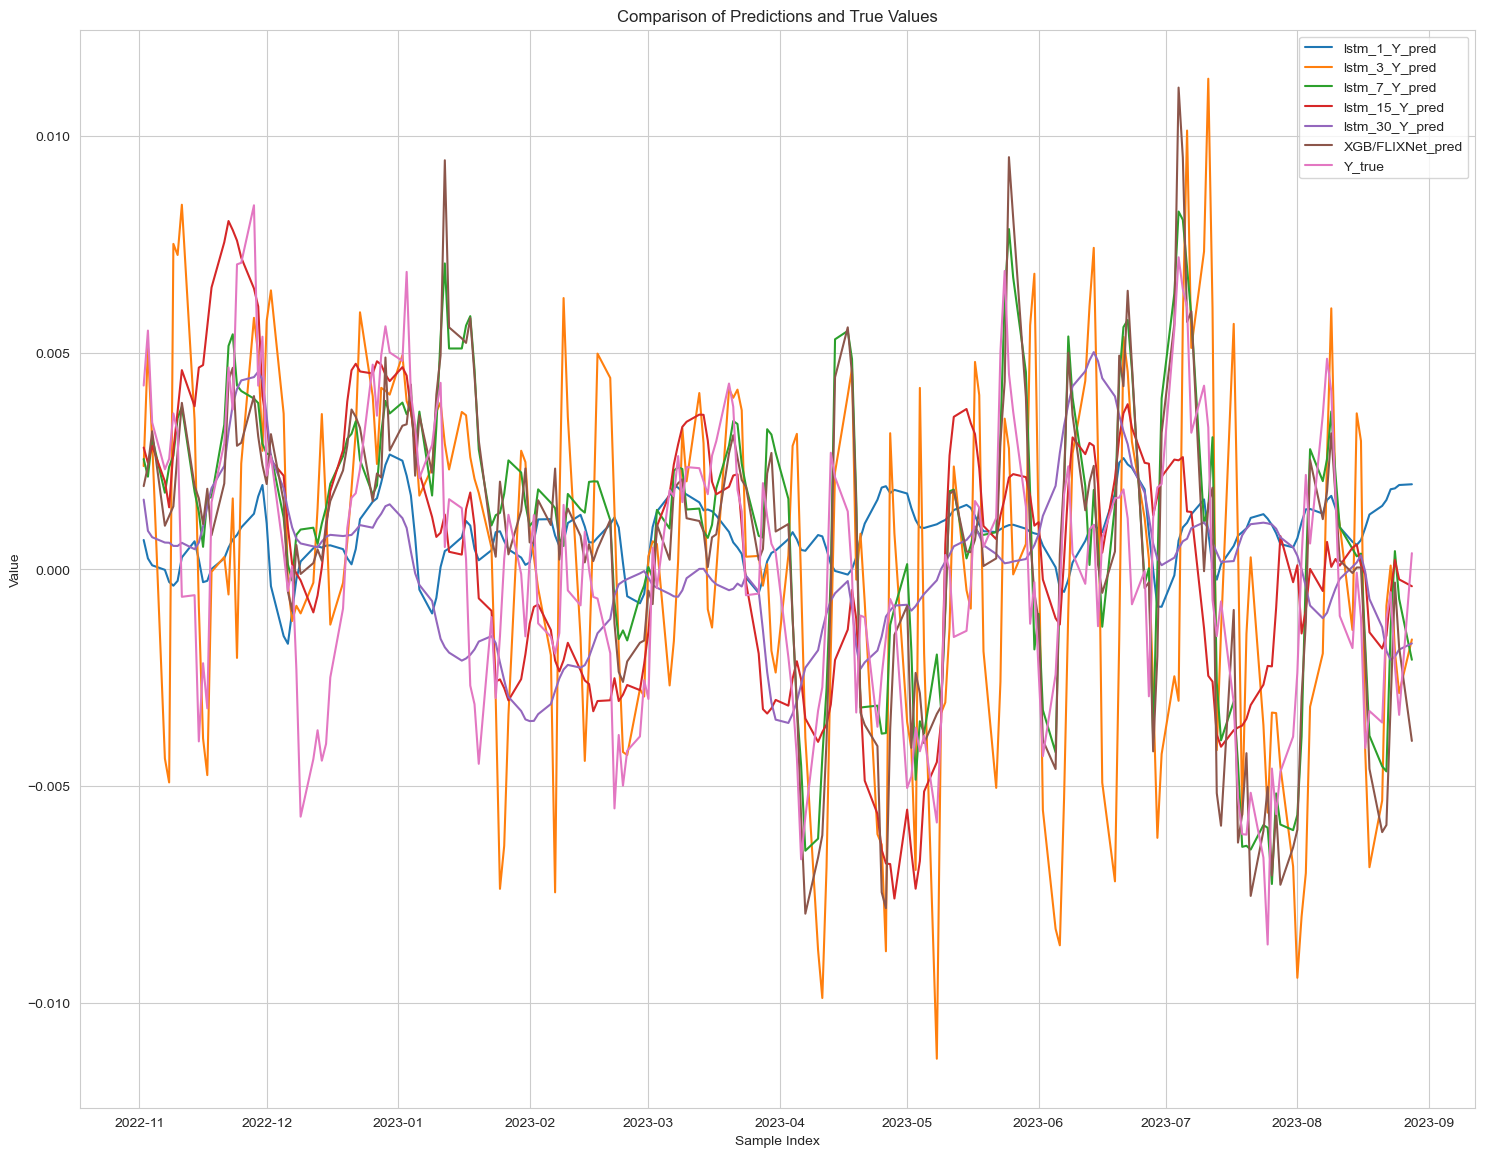

In [13]:
# 画一个折线图，每一列是一个折线
plt.figure(figsize=(18, 14))
for column in df_all.columns:
    plt.plot(df_all[column], label=column)
    
plt.title('Comparison of Predictions and True Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

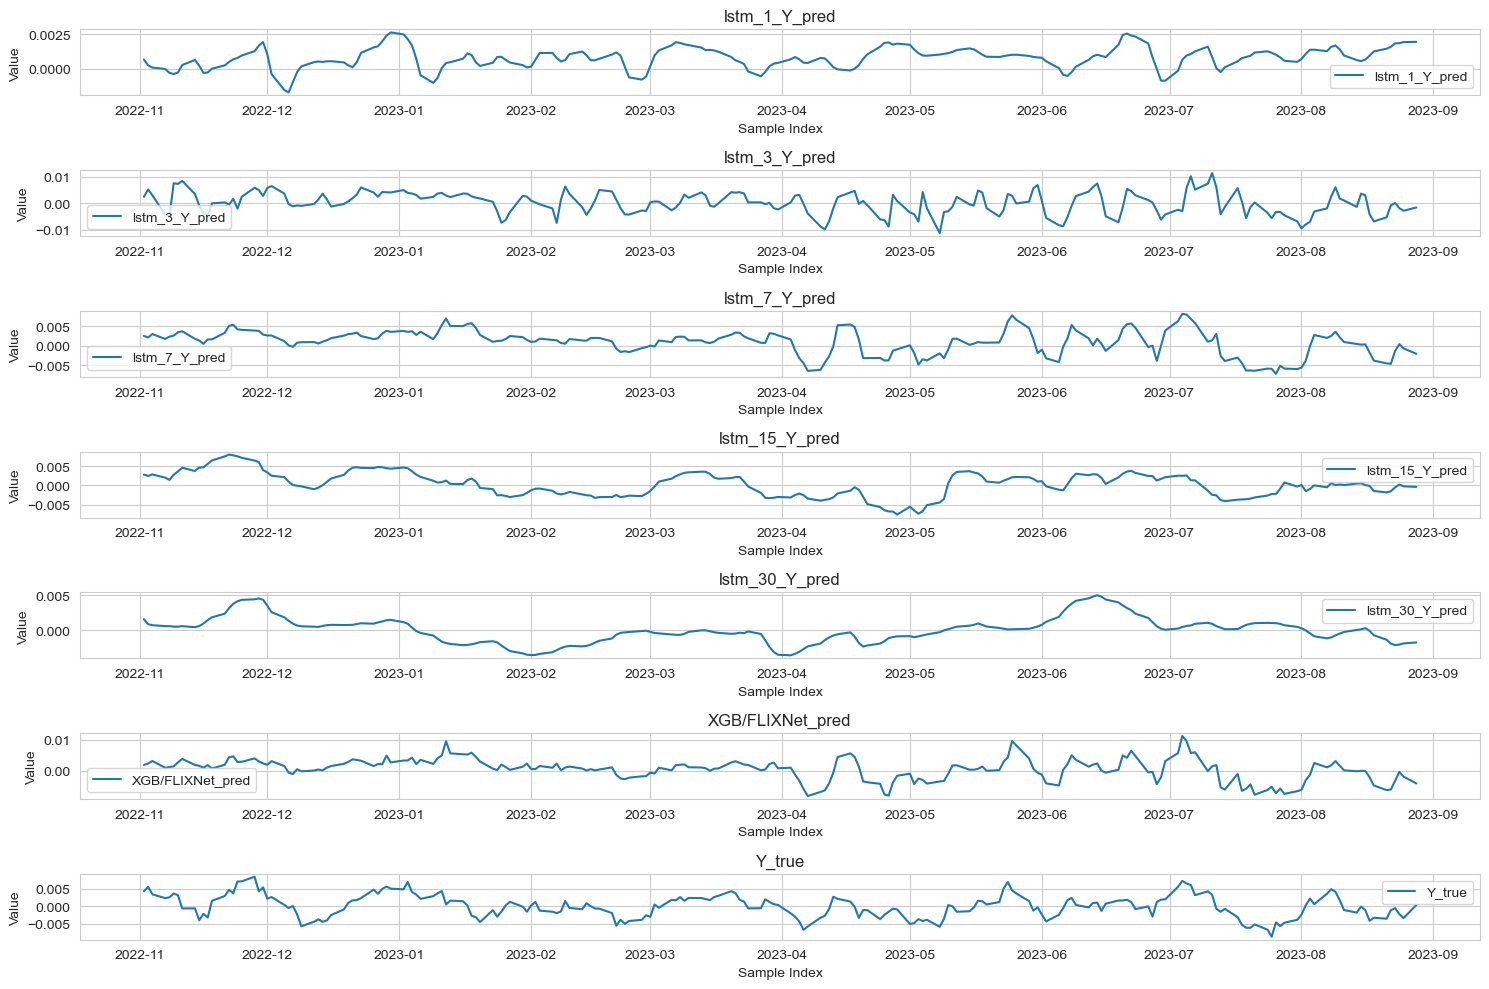

In [22]:
# 画一个垂直排列的多个子图，每个子图是一个折线
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_all.columns):
    plt.subplot(len(df_all.columns), 1, i + 1)
    plt.plot(df_all[column], label=column)
    plt.title(column)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    #间距
    plt.tight_layout()
    
    

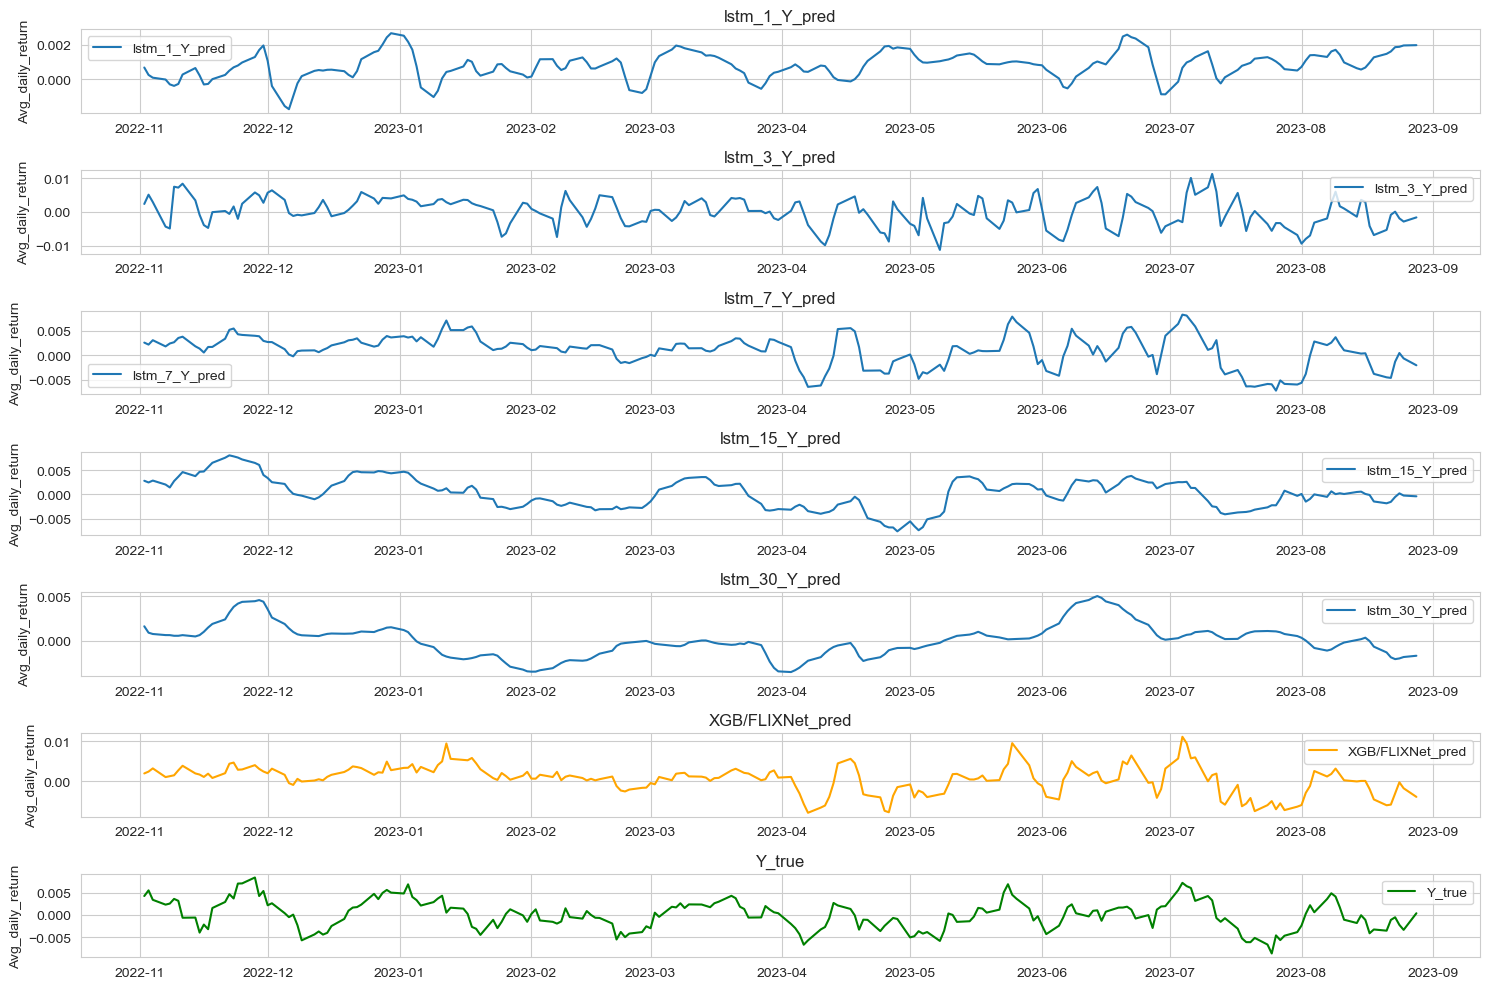

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
subplot_index = 1
for i, column in enumerate(df_all.columns):
    if column == 'Y_true':
        # 如果是真实值，使用绿色
        plt.subplot(len(df_all.columns), 1, subplot_index)
        plt.plot(df_all[column], label=column, color='green')
    elif column == 'XGB/FLIXNet_pred':
        # 使用橙色
        plt.subplot(len(df_all.columns), 1, subplot_index)
        plt.plot(df_all[column], label=column, color='orange')
    else:
        # 如果是预测值，使用蓝色
        plt.subplot(len(df_all.columns), 1, subplot_index)
        plt.plot(df_all[column], label=column)
    plt.title(column)
    # plt.xlabel('Sample Index')
    plt.ylabel('Avg_daily_return')
    plt.legend()
    plt.tight_layout()
    subplot_index += 1

# 保存高清图片
plt.savefig('comparison_subplot.png', dpi=300)

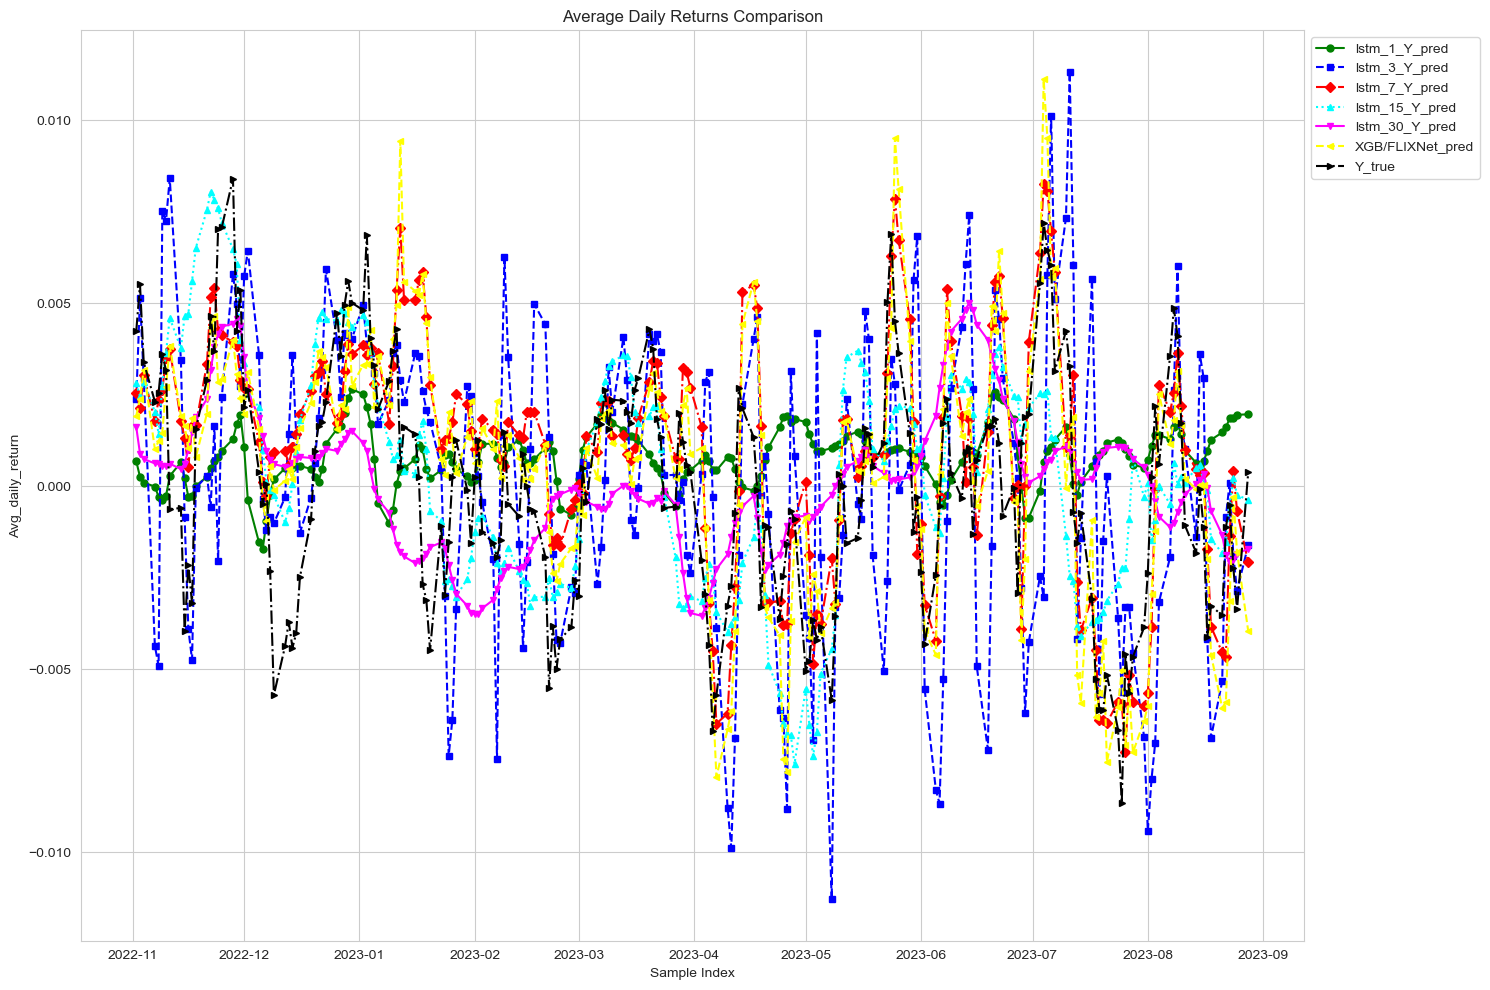

In [26]:
# 设定图形大小
plt.figure(figsize=(15, 10))

# 为不同的折线选择颜色和样式
colors = ['green', 'blue', 'red', 'cyan', 'magenta', 'yellow', 'black']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', 'D', '^', 'v', '<', '>']

# 绘制每个列的数据
for i, column in enumerate(df_all.columns):
    plt.plot(df_all.index, df_all[column], label=column, color=colors[i], linestyle=linestyles[i], marker=markers[i], markersize=5)

# 设置图表标题和坐标轴标签
plt.title('Average Daily Returns Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Avg_daily_return')

# 调整图例位置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 优化布局
plt.tight_layout()
# 保存高清图片
plt.savefig('comparison_inOne.png', dpi=300)


ValueError: num must be an integer with 1 <= num <= 6, not 7

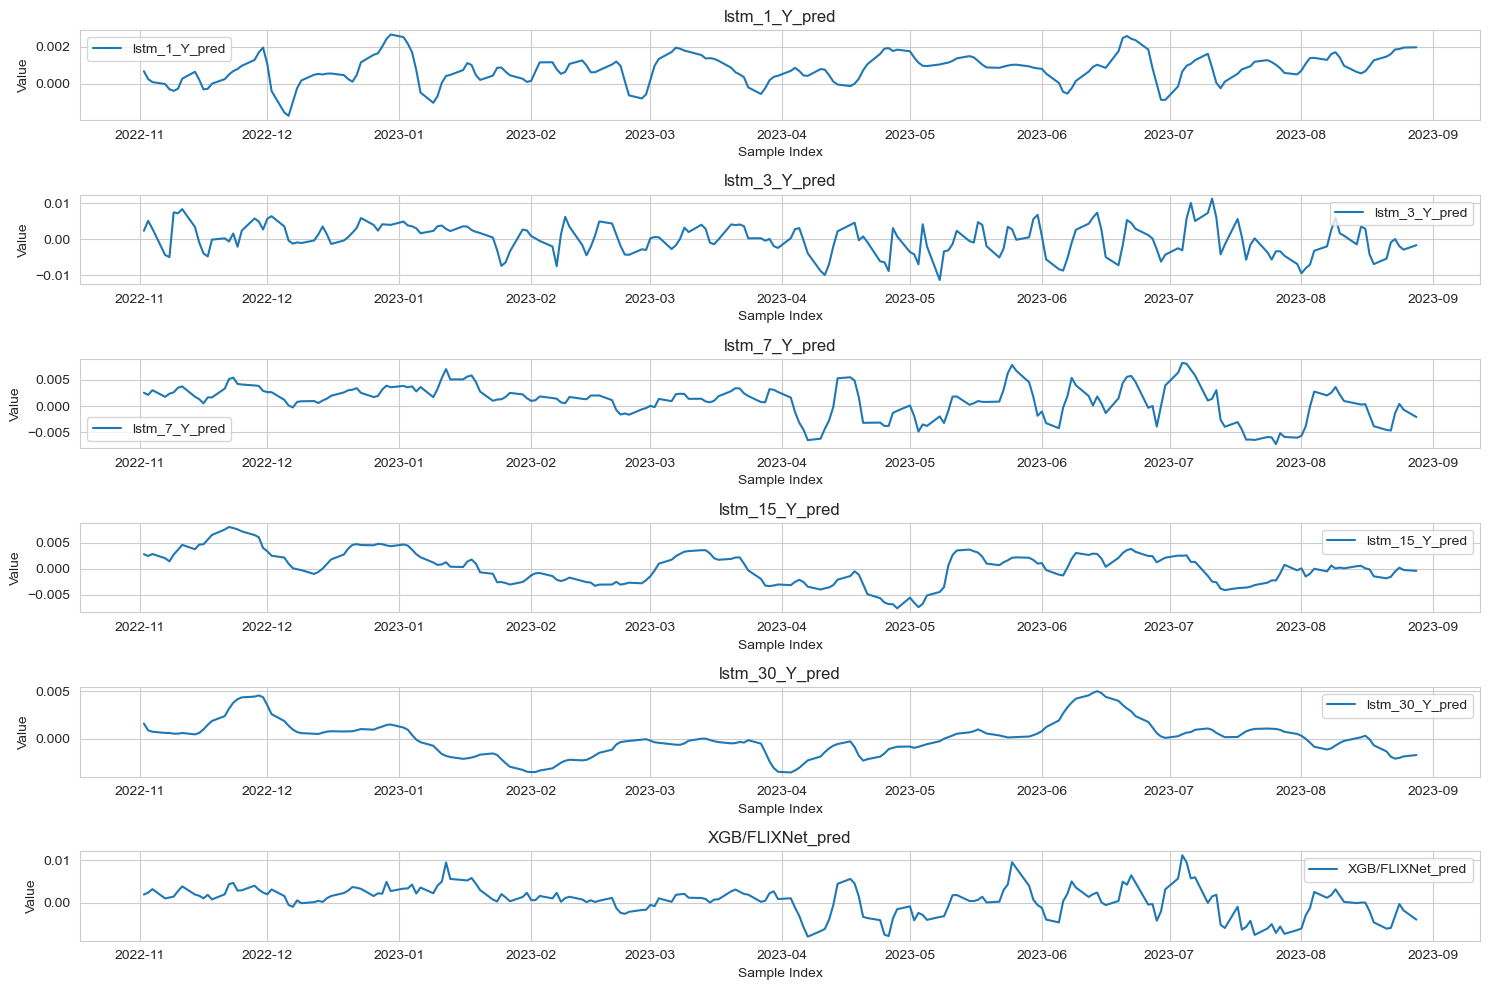

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
subplot_index = 1
for i, column in enumerate(df_all.columns):
    if column == 'XGB_pred':
        continue
    if column == 'Y_true':
        # 如果是真实值，使用绿色
        plt.subplot(len(df_all.columns)-1, 1, subplot_index)
        plt.plot(df_all[column], label=column, color='green')
    else:
        # 如果是预测值，使用蓝色
        plt.subplot(len(df_all.columns)-1, 1, subplot_index)
        plt.plot(df_all[column], label=column)
    plt.title(column)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    subplot_index += 1

# 保存高清图片
plt.savefig('comparison.png', dpi=300)

# 评估指标

In [18]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 214 entries, 2022-11-02 to 2023-08-28
Freq: B
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lstm_1_Y_pred     214 non-null    float32
 1   lstm_3_Y_pred     214 non-null    float32
 2   lstm_7_Y_pred     214 non-null    float32
 3   lstm_15_Y_pred    214 non-null    float32
 4   lstm_30_Y_pred    214 non-null    float32
 5   XGB/FLIXNet_pred  214 non-null    float32
 6   Y_true            214 non-null    float32
dtypes: float32(7)
memory usage: 7.5 KB


In [20]:
# 计算R2
from sklearn.metrics import r2_score

df = df_all
# 假设 df 是你的 DataFrame
# 你可以通过类似这样的代码来加载数据
# df = pd.read_csv('你的数据文件.csv')

# 计算每个预测列的 R2 值
r2_scores = {}
y_true = df['Y_true']  # 真实值列
columns = ['lstm_1_Y_pred', 'lstm_3_Y_pred', 'lstm_7_Y_pred', 'lstm_15_Y_pred', 'lstm_30_Y_pred', 'XGB/FLIXNet_pred']

for column in columns:
    y_pred = df[column]
    r2_scores[column] = r2_score(y_true, y_pred)

# 输出 R2 值
for model, score in r2_scores.items():
    print(f"{model}: R^2 = {score:.4f}")

lstm_1_Y_pred: R^2 = -0.0563
lstm_3_Y_pred: R^2 = -0.5226
lstm_7_Y_pred: R^2 = 0.3402
lstm_15_Y_pred: R^2 = 0.2142
lstm_30_Y_pred: R^2 = 0.0017
XGB/FLIXNet_pred: R^2 = 0.2634


In [1]:
from model.LSTM_base_model import best_lstms

best_lstms = best_lstms()
best_lstms

[{'T': 1,
  'window_size': 20,
  'hidden_dim': 30,
  'num_layers': 3,
  'model_path': 'lstm_models_6\\best_lstm_model_T1_window20_hidden30_layers3.pth',
  'val_r2': (1, -0.01605886870318951)},
 {'T': 2,
  'window_size': 20,
  'hidden_dim': 30,
  'num_layers': 3,
  'model_path': 'lstm_models_6\\best_lstm_model_T2_window20_hidden30_layers3.pth',
  'val_r2': (2, 0.25054216315445077)},
 {'T': 3,
  'window_size': 20,
  'hidden_dim': 30,
  'num_layers': 3,
  'model_path': 'lstm_models_6\\best_lstm_model_T3_window20_hidden30_layers3.pth',
  'val_r2': (3, 0.23233631387955556)},
 {'T': 4,
  'window_size': 20,
  'hidden_dim': 30,
  'num_layers': 3,
  'model_path': 'lstm_models_6\\best_lstm_model_T4_window20_hidden30_layers3.pth',
  'val_r2': (4, 0.40065375631511724)},
 {'T': 5,
  'window_size': 20,
  'hidden_dim': 30,
  'num_layers': 3,
  'model_path': 'lstm_models_6\\best_lstm_model_T5_window20_hidden30_layers3.pth',
  'val_r2': (5, 0.4024103484078506)},
 {'T': 6,
  'window_size': 20,
  'hidden

In [2]:

 # {'T': 23,
 #  'window_size': 20,
 #  'hidden_dim': 30,
 #  'num_layers': 3,
 #  'model_path': 'lstm_models_6\\best_lstm_model_T23_window20_hidden30_layers3.pth',
 #  'val_r2': (23, -0.1030608931312682)},
 
 # 可视化T与R2
import matplotlib.pyplot as plt

# 从字典中提取 T 和 R2 值
T_values = [T for T, _ in best_lstms]
r2_values = [r2 for _, r2 in best_lstms]

# 创建一个新的图表
plt.figure(figsize=(10, 6))

# 绘制 T 和 R2 值
plt.plot(T_values, r2_values, marker='o')

# 添加标题和坐标轴标签
plt.title('R2 vs. T')
plt.xlabel('T')
plt.ylabel('R2')

# 显示网格线
plt.grid(True)

# 显示图表


ValueError: too many values to unpack (expected 2)